In [1]:
import os
import copy
import warnings
import logging
import sqlite3
import numpy as np
import healpy as hp
import skyproj
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

from zoneinfo import ZoneInfo

timezone = "Chile/Continental"
tz = ZoneInfo(timezone)
tz_utc = ZoneInfo("UTC")


from rubin_scheduler.scheduler.utils import generate_all_sky
from rubin_scheduler.scheduler.model_observatory import ModelObservatory

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site, angular_separation

from rubin_scheduler.scheduler.utils import SchemaConverter, run_info_table
import rubin_sim.maf.plots as plots
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metric_bundles as mb
import rubin_sim.maf.batches as batches
from rubin_sim.maf.db import ResultsDb

# If running on the USDF, find rubin_scheduler data here:
if "usdf" in os.getenv("EXTERNAL_INSTANCE_URL", ""):
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

In [2]:
visits = {}
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    conn = sqlite3.connect(run_name + '.db')
    visits[run_name] = pd.read_sql('select * from observations', conn)

In [3]:
# Label all visits that overlap deep footprint, even if not part of separate survey
dd_ra = 310
dd_dec = -50
radius = np.sqrt(100 / np.pi)
nside = 128
sky = generate_all_sky(nside=128)
dist = angular_separation(dd_ra, dd_dec, sky['ra'], sky['dec'])
close = np.where(dist <= radius)[0]
dd = np.zeros(hp.nside2npix(nside))
dd[close] = 1

stacker = stackers.WFDlabelStacker(footprint=dd, exclude_dd=False, fp_threshold=0.4, area_id_name="Deep")
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    newvisits = stacker.run(visits[run_name].to_records(index=False))
    visits[run_name] = pd.DataFrame(newvisits)

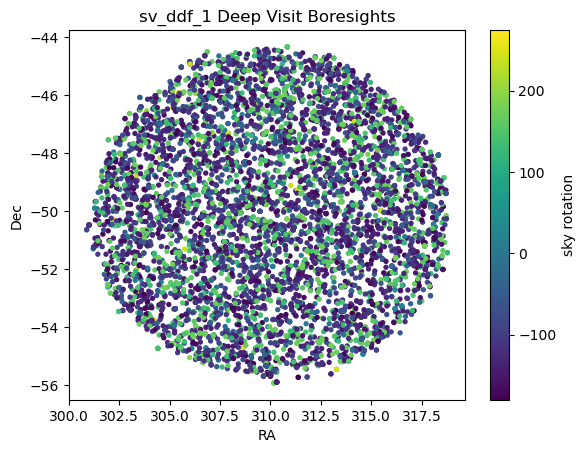

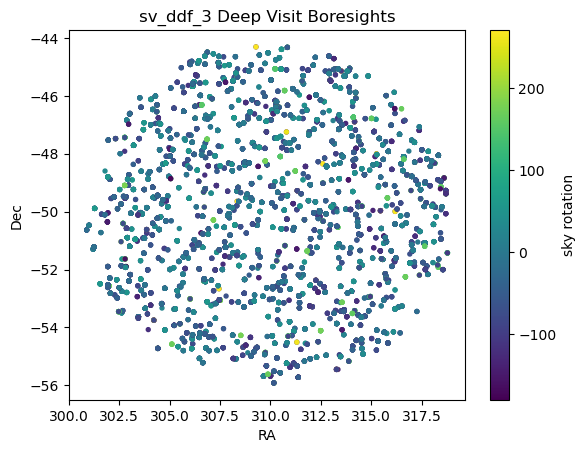

In [4]:
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    plt.figure()
    q = visits[run_name].query('area_id == "Deep"')
    plt.scatter(q.fieldRA, q.fieldDec, c=q.rotSkyPos, s=8)
    plt.colorbar(label='sky rotation')
    plt.xlabel("RA")
    plt.ylabel("Dec")
    plt.title(run_name + " Deep Visit Boresights")

In [5]:
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    print(run_name, len(visits[run_name].query('scheduler_note.str.contains("DD")')), len(visits[run_name].query('area_id == "Deep"')), len(visits[run_name]))

sv_ddf_1 3903 6322 50597
sv_ddf_3 0 9336 52378


In [6]:
nside = 64
survey_start = Time(visits['sv_ddf_1'].observationStartMJD.min(), format='mjd', scale='utc')
model_obs = ModelObservatory(nside=nside, 
                           mjd=survey_start.mjd, 
                           mjd_start=survey_start.mjd, 
                           cloud_data="ideal", # noclouds
                           seeing_data=None, # standard seeing, but could modify
                           wind_data=None,
                           downtimes = "ideal",
                            no_sky=True)
# Slow the telescope down with smaller jerk/acceleration, and smaller maxvel
# But is faster with settle of 0 (Tiago is working on this)
model_obs.setup_telescope(
    altitude_maxspeed=2.0,
    altitude_accel=2.0,
    altitude_jerk=8.0,
    azimuth_maxspeed=2.0,
    azimuth_accel=2.0,
    azimuth_jerk=8.0,
    settle_time=0.0,
)

In [7]:
nights = np.arange(1, 80.5, 1)

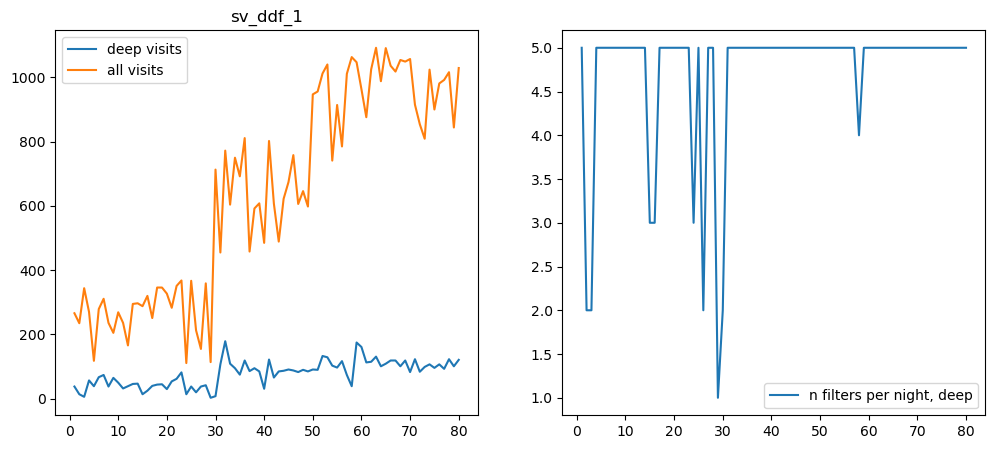

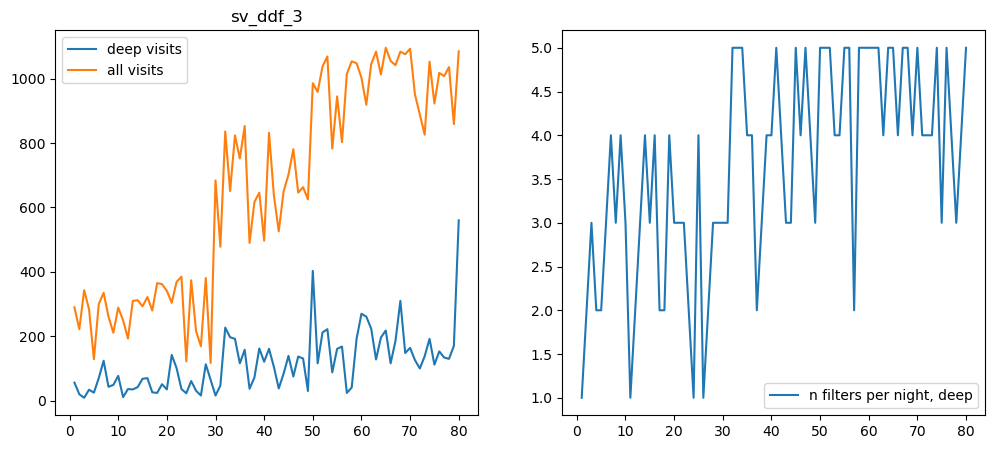

In [8]:
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    deep = visits[run_name].query('area_id == "Deep"')
    nd = deep.groupby('night').agg(deep_visits = ("observationStartMJD", "count"), t_start = ("observationStartMJD", "first"), n_filters = ('band', 'nunique'))
    na = visits[run_name].groupby('night').agg(all_visits = ("observationStartMJD", "count"))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax = axes[0]
    ax.plot(nd.index.values, nd.deep_visits.values, label='deep visits')
    ax.plot(na.index.values, na.all_visits.values, label='all visits')
    ax.legend()
    ax.set_title(run_name)
    ax = axes[1]
    ax.plot(nd.index.values, nd.n_filters.values, label='n filters per night, deep')
    ax.legend()

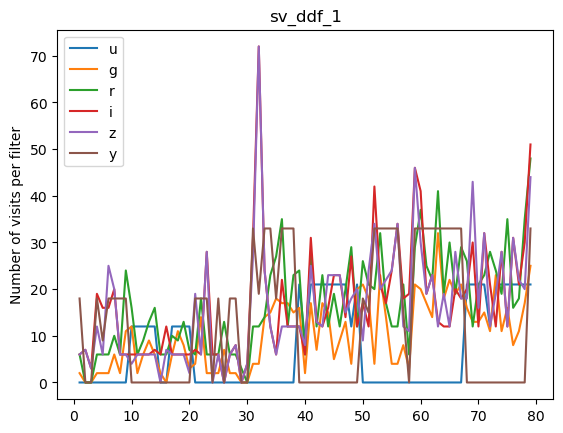

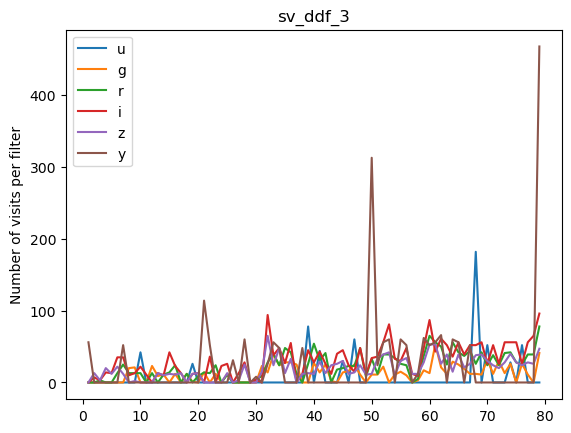

In [9]:
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    plt.figure()
    deep = visits[run_name].query('area_id == "Deep"')
    nv = {}
    for b in 'ugrizy':
        q = deep.query('band == @b')
        nv[b], _ = np.histogram(q.night.values, bins=nights)
        plt.plot(nights[:-1], nv[b], label=b)
        plt.legend()
        plt.ylabel("Number of visits per filter")
        plt.title(run_name)

In [10]:
hpixnside = 512
deep_slicer, plot_dict = slicers.make_circle_subset_slicer(dd_ra, dd_dec, radius=radius*1.5, nside=hpixnside, use_cache=False)

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


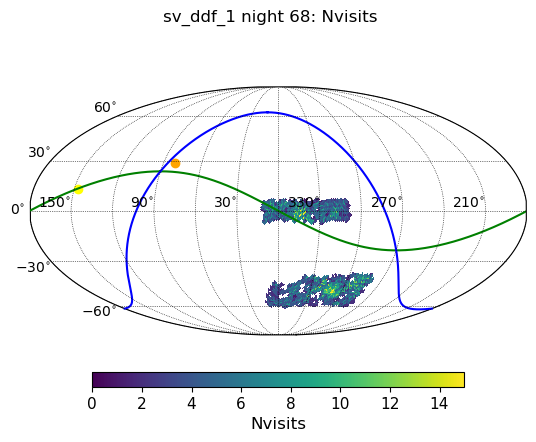

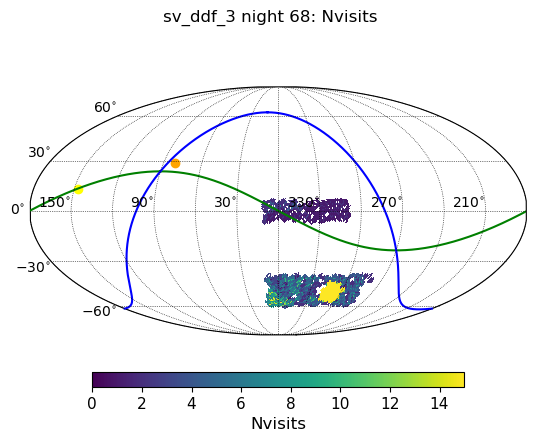

In [12]:
night = 68
for run_name in ['sv_ddf_1', 'sv_ddf_3']:
    q = visits[run_name].query('night == @night')
    m = metrics.CountMetric('observationStartMJD', metric_name='Nvisits')
    s = slicers.HealpixSlicer(nside=64)
    constraint = f'night {night}'
    plot_funcs = [plots.HpxmapPlotter()]
    model_obs.mjd = q.observationStartMJD.mean()
    plot_dict = {'xlabel': 'Nvisits', 'fontsize': 'large',
                 'color_min': 0, 'color_max': 15,
                 'model_observatory': model_obs, 
                 'decorations': ['galactic_plane', 'ecliptic', 'moon', 'sun']}
    b = mb.MetricBundle(m, s, constraint, run_name=run_name, 
                        plot_funcs=plot_funcs, plot_dict=plot_dict)
    g = mb.MetricBundleGroup({"nvis": b}, None, out_dir=run_name)
    g.run_current(constraint, q.to_records())
    figdict = b.plot()
    if 'Skyproj' in figdict:
        figdict['Skyproj'].gca().set_xlabel(plot_dict["xlabel"], visible=False)